In [1]:
from itertools import product
import numpy as np
import pandas as pd
from pulp import *
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## OpenCV

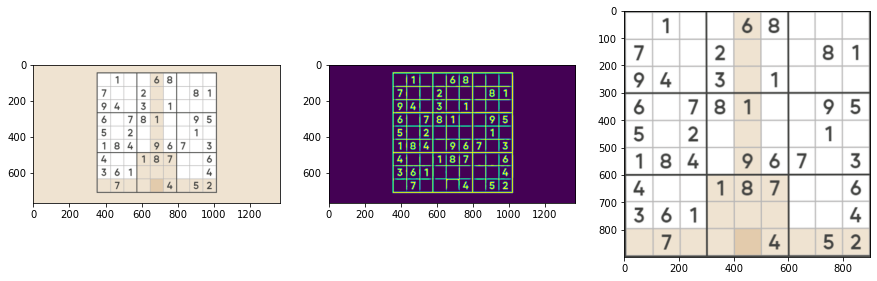

In [2]:
# Открываем изображение с судоку
img = cv2.imread('examples/9.png')

# Находим контуры на изображении
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurry = cv2.GaussianBlur(gray, (5, 5), 5)
thresh = cv2.adaptiveThreshold(blurry, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
grabs,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
grabs = sorted(grabs, key=cv2.contourArea, reverse=True)

# Для поиска сетки судоку находим наибольший квадрат на изображении
location = None
for grab in grabs:
    approx = cv2.approxPolyDP(grab, 15, True)
    if len(approx) == 4:
        rect = np.zeros((4, 2), dtype = "float32")
        cutt = approx[:,0]
        s = cutt.sum(axis = 1)
        
        # Сортировка углов по часовой стрелке
        rect[0] = cutt[np.argmin(s)]
        rect[2] = cutt[np.argmax(s)]
        diff = np.diff(cutt, axis = 1)
        rect[1] = cutt[np.argmin(diff)]
        rect[3] = cutt[np.argmax(diff)]
        location = rect
        break

# Создаём квадрат 900х900
height = 900
width = 900
pts1 = np.float32([location[0], location[1], location[3], location[2]])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Вписываем судоку в наш квадрат
matrix = cv2.getPerspectiveTransform(pts1, pts2)
board = cv2.warpPerspective(img, matrix, (width, height))

fig, ax = plt.subplots(1,3, figsize=(15,15))
for i, j in zip(range(len(ax)), [img, thresh, board]):
    ax[i].imshow(j)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\lol\anaconda3\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
C:\Users\lol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\lol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


,1,2,3,4,5,6,7,8,9
1,,1,,,6,8,,,
2,7,,,2,,,,8,1
3,9,,,3,,1,,,
4,6,,7,8,1,,,9,5
5,5,,2,,,,,1,
6,1,8,4,,9,6,7,,3
7,4,,,1,8,7,,,6
8,3,6,1,,,,,,
9,,7,,,,4,,5,2


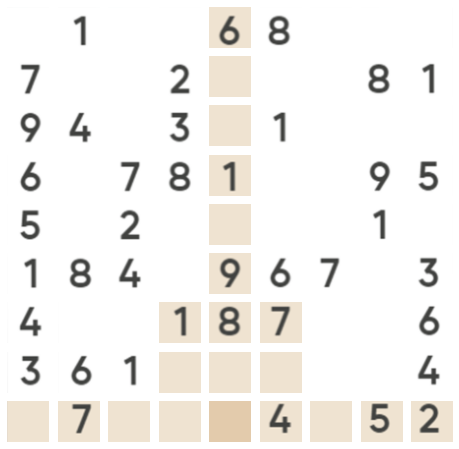

In [3]:
# Загружаем модель OCR
import easyocr
reader = easyocr.Reader(['en'])

# Создаём датафрейм и список для записи распознанных результатов
df = pd.DataFrame(index=range(1, 10), columns=range(1, 10))
sudoku_map = []

# Создаём оси для отрисовки разделённых изображений
fig, ax = plt.subplots(9, 9, figsize=(8,8))

# Разделяем наш судоку на 9 строк и 9 столбцов (так как размер изображения 900х900) и распознаём каждое значение по отдельности
split = np.split(board, 9, axis=1)
for col,j  in enumerate(split):
    digs = np.split(j, 9)
    for row,d in enumerate(digs):
        d = d[10:90,10:90]
        cv2.copyMakeBorder(d,10,10,10,10,cv2.BORDER_CONSTANT)
        ax[row][col].imshow(d)
        ax[row][col].axis('off')

        text = reader.readtext(d, allowlist='0123456789', detail=False)
        if len(text) > 0:
            df.iloc[row, col] = text[0]
            sudoku_map.append([text[0], str(row+1), str(col+1)])

df.fillna('', inplace=True)
df

## Pulp

In [4]:
# Создаём списки для перебора в Pulp
nums = [*map(str, [*range(1,10)])] # список чисел от 1 до 9 со строковым типом
rows = nums
cols = nums
vals = nums

# Создаём Pulp словарь с переменными возможных ответов
choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)

# Создаём задачу для Pulp
prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # Задаётся нулём, так как нас интересует только подбор значения согласно ограничениям

In [5]:
# Задаём ограничениями условие, что каждое число в каждой строке и каждом столбце должно повторяться не более 1 раза
for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

In [6]:
# Задаём аналогичные ограничения для сеток 3х3
grid = (range(3), range(3))
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(*grid)] for i,j in product(*grid)]
for v,s in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in s]) == 1, ""

# Записываем в задачу известные значения, распознанные OCR
for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

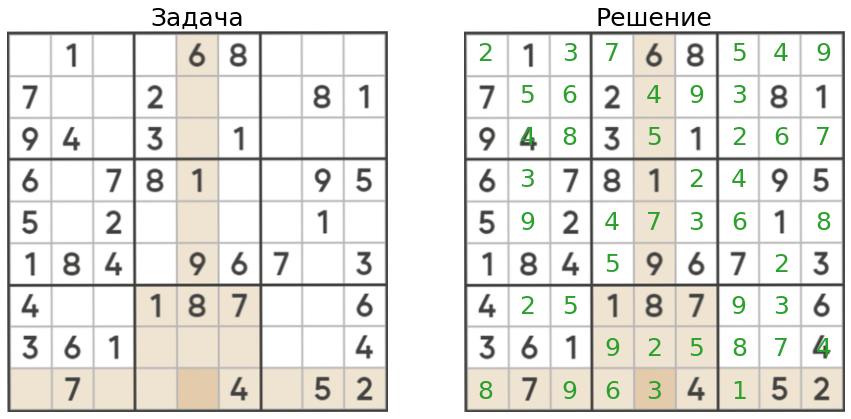

In [7]:
# Решаем задачу
prob.solve()

# Отрисовка конечного результата
fig, ax = plt.subplots(1,2, figsize=(15,15))
for a in ax:
    a.axis('off')
ax[0].imshow(board)
ax[0].set_title('Задача', fontsize=25)
ax[1].imshow(board)
ax[1].set_title('Решение', fontsize=25)

# Пишем решение поверх изображения
y = 50
for r in rows:
    x = 50
    for c,v in product(cols, vals):
        if choices[v][r][c].value() == 1:
            if [v,r,c] not in sudoku_map: # Пишем только подобранные значения
                ax[1].text(x,y,v, ha='center', va='center', fontsize=25, color='tab:green') 
            x += 100
    y += 100
